# Proyecto Aerya: EDA, metricas, embeddings, agente y FastApi

Objetivo:
- EDA 
- Metricas de impacto para la aerolinea con scikit-learn.
- Embeddings locales con Ollama.
- Agente con LangGraph usando OpenAI (API).
- End point con FastApi



## 1. Configuracion y rutas

In [1]:
# ENV CONFIG (primera celda)

import os
from dotenv import load_dotenv

load_dotenv()

if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY no esta definida en .env")


In [2]:
import logging
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple

import json
import re

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 120)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    force=True,
)
logger = logging.getLogger("aerya")

BASE_DIR = Path("data")
THREADS_PATH = BASE_DIR / "Threads.json"
MESSAGES_PATH = BASE_DIR / "Messages.json"

if not BASE_DIR.exists():
    raise FileNotFoundError(f"La carpeta de datos no existe: {BASE_DIR.resolve()}")
if not THREADS_PATH.exists() or not MESSAGES_PATH.exists():
    raise FileNotFoundError(f"Faltan archivos JSON en {BASE_DIR.resolve()}")

class DataValidationError(Exception):
    pass

class EmbeddingError(Exception):
    pass

class ModelTrainingError(Exception):
    pass

class AgentError(Exception):
    pass
def validar_columnas(df: pd.DataFrame, required: set[str], contexto: str) -> None:
    missing = required - set(df.columns)
    if missing:
        raise DataValidationError(f"Faltan columnas en {contexto}: {missing}")

## 2. Carga y estructura

In [3]:
def cargar_datos(ruta_threads: Path, ruta_messages: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if not ruta_threads.exists() or not ruta_messages.exists():
        raise FileNotFoundError("No se encuentran los archivos JSON.")

    logger.info("Cargando datos desde %s y %s ...", ruta_threads, ruta_messages)

    try:
        df_threads = pd.read_json(ruta_threads)
        df_messages = pd.read_json(ruta_messages)
    except ValueError as exc:
        raise DataValidationError(f"JSON malformado o estructura incompatible: {exc}") from exc

    if df_threads.empty or df_messages.empty:
        raise DataValidationError("Alguno de los JSON esta vacio.")

    logger.info(
        "Datos cargados: threads=%d filas, messages=%d filas",
        len(df_threads),
        len(df_messages),
    )
    return df_threads, df_messages


def mostrar_estructura(df: pd.DataFrame, nombre: str, head_rows: int = 3) -> None:
    print(f"DATAFRAME: {nombre}")
    print(f"Dimensiones: {df.shape}")
    print("\nColumnas")
    print(df.columns.tolist())
    print("\nResumen de tipos y nulos")
    df.info()
    print(f"\nHead ({head_rows})")
    print(df.head(head_rows))
    print("-" * 60)


try:
    df_threads, df_messages = cargar_datos(THREADS_PATH, MESSAGES_PATH)
    mostrar_estructura(df_threads, "df_threads")
    mostrar_estructura(df_messages, "df_messages")
except (FileNotFoundError, DataValidationError) as exc:
    logger.error("Error durante la carga: %s", exc)
except Exception as exc:
    logger.error("Error inesperado en carga: %s", exc)

2026-02-09 14:49:39,184 - aerya - INFO - Cargando datos desde data\Threads.json y data\Messages.json ...
2026-02-09 14:49:52,483 - aerya - INFO - Datos cargados: threads=11500 filas, messages=135848 filas


DATAFRAME: df_threads
Dimensiones: (11500, 41)

Columnas
['_id', 'thread_id', 'client', 'source', 'user', 'status', 'get_user_info', 'check_pnr', 'lookup_policy', 'availability', 'best_flight_option', 'booking', 'escalate_conversation', 'created_at', 'updated_at', 'check_flight_schedule', 'correlative_id', 'ai_resolved', 'ended_reason', 'flags', 'Checked_PNR', 'end_conversation', 'pnr', 'is_guest', 'email', 'last_tool_used', 'last_interaction_timestamp', 'checked_pnrs', 'cancel_purchase', 'Checked_pnrs', 'refund', 'check_in', 'escalated_at', 'escalation_summary', 'escalation_whatsapp_url', 'platform', 'comments', 'org_id', 'display_id', 'correlative_numeric', 'lookup_policy_count']

Resumen de tipos y nulos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         11500 non-null  object 
 1 

## 3. EDA

In [4]:
def _get_hashable_df(df: pd.DataFrame) -> pd.DataFrame:
    temp_df = df.copy()
    object_cols = temp_df.select_dtypes(include=["object"]).columns
    temp_df[object_cols] = temp_df[object_cols].astype(str).replace("nan", pd.NA)
    return temp_df


def _profile_missing(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    missing = df.isna().sum().sort_values(ascending=False)
    return missing[missing > 0].head(top_n).to_frame(name="missing_count")

    
def _profile_uniques(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    safe_df = _get_hashable_df(df)
    uniques = safe_df.nunique(dropna=True).sort_values(ascending=False).head(top_n)
    return uniques.to_frame(name="unique_values")


def _safe_duplicated_count(df: pd.DataFrame) -> int:
    safe_df = _get_hashable_df(df)
    return safe_df.duplicated().sum()


def analizar_dataset(df: pd.DataFrame, nombre: str) -> None:
    print(f"ANALISIS DEL DATASET: {nombre}")
    print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")

    n_duplicados = _safe_duplicated_count(df)
    perc_duplicados = (n_duplicados / len(df)) * 100 if len(df) else 0
    print(f"Duplicados: {n_duplicados} ({perc_duplicados:.2f}%)")

    print("\nTop 15 columnas con faltantes")
    missing_df = _profile_missing(df, top_n=15)
    if missing_df.empty:
        print("No hay valores faltantes.")
    else:
        print(missing_df)

    print("\nTop 15 columnas con valores unicos")
    print(_profile_uniques(df, top_n=15))
    print("-" * 60)


analizar_dataset(df_threads, "df_threads")
analizar_dataset(df_messages, "df_messages")

ANALISIS DEL DATASET: df_threads
Dimensiones: 11500 filas x 41 columnas
Duplicados: 0 (0.00%)

Top 15 columnas con faltantes
                            missing_count
comments                            11495
lookup_policy_count                 11491
org_id                              11484
display_id                          11484
correlative_numeric                 11484
Checked_PNR                         11478
escalated_at                        11398
escalation_summary                  11398
escalation_whatsapp_url             11398
flags                               10850
end_conversation                    10784
Checked_pnrs                         8970
platform                             6765
last_tool_used                       1947
last_interaction_timestamp            930

Top 15 columnas con valores unicos
                            unique_values
_id                                 11500
created_at                          11500
correlative_id                      11500

## 4. Tabla maestra (ETL)

In [5]:
def _to_snake_case(name: str) -> str:
    name = name.strip()
    name = re.sub(r"[\s\-]+", "_", name)
    name = re.sub(r"[^0-9a-zA-Z_]+", "", name)
    name = re.sub(r"_+", "_", name)
    return name.lower()

#normalizar contenido de texto
def _normalize_text_content(value: Any) -> str:
    if value is None:
        return ""
    if isinstance(value, float) and pd.isna(value):
        return ""
    if isinstance(value, (list, tuple, set)):
        return "; ".join(str(item) for item in value)
    if isinstance(value, dict):
        return json.dumps(value, ensure_ascii=False)
    return str(value).strip()

#normalizar columnas
def normalizar_columnas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [_to_snake_case(col) for col in df.columns]
    return df


#extraer fecha
def _extract_date_value(value: Any) -> Optional[str]:
    if isinstance(value, dict) and "$date" in value:
        return value["$date"]
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return None
    return str(value)


#crear tabla maestra
def crear_tabla_maestra(df_t: pd.DataFrame, df_m: pd.DataFrame) -> pd.DataFrame:
    df_t = normalizar_columnas(df_t)
    df_m = normalizar_columnas(df_m)

    validar_columnas(df_t, {"thread_id"}, "threads")
    validar_columnas(df_m, {"thread_id", "content"}, "messages")

    if "created_at" in df_t.columns:
        df_t["created_at"] = pd.to_datetime(
            df_t["created_at"].map(_extract_date_value), errors="coerce", utc=True
        )

    col_fecha_msg = "created_at" if "created_at" in df_m.columns else "createdat"
    if col_fecha_msg in df_m.columns:
        df_m["msg_timestamp"] = pd.to_datetime(
            df_m[col_fecha_msg].map(_extract_date_value), errors="coerce", utc=True
        )
    else:
        df_m["msg_timestamp"] = pd.NaT

    df_m = df_m.sort_values(by=["thread_id", "msg_timestamp"])
    df_m["clean_content"] = df_m["content"].apply(_normalize_text_content)

    df_grouped = df_m.groupby("thread_id").agg(
        full_conversation=("clean_content", lambda x: " | ".join(x[x != ""])),
        msg_count=("clean_content", "count"),
        first_msg=("msg_timestamp", "min"),
        last_msg=("msg_timestamp", "max"),
    ).reset_index()

    if df_grouped.empty:
        raise DataValidationError("No se pudieron agrupar mensajes por thread_id.")

    threads_antes = len(df_t)
    df_master = pd.merge(df_t, df_grouped, on="thread_id", how="inner")
    threads_perdidos = threads_antes - len(df_master)

    if df_master.empty:
        raise DataValidationError("La tabla maestra quedo vacia tras el merge.")

    if threads_perdidos > 0:
        logger.warning(
            "Merge: %d threads sin mensajes fueron descartados (%d -> %d)",
            threads_perdidos, threads_antes, len(df_master),
        )

    df_master["duration_minutes"] = (
        (df_master["last_msg"] - df_master["first_msg"]).dt.total_seconds() / 60
    ).fillna(0)

    return df_master


try:
    df_master = crear_tabla_maestra(df_threads, df_messages)
    logger.info("Tabla maestra creada correctamente - Dimensiones: %s", df_master.shape)
    print(df_master[["thread_id", "msg_count", "duration_minutes"]].head(3))
except DataValidationError as exc:
    logger.error("Error de validacion en tabla maestra: %s", exc)
except Exception as exc:
    logger.error("Error en la tabla maestra: %s", exc)

2026-02-09 14:50:04,636 - aerya - WARNING - Merge: 207 threads sin mensajes fueron descartados (11500 -> 11293)
2026-02-09 14:50:04,728 - aerya - INFO - Tabla maestra creada correctamente - Dimensiones: (11293, 46)


       thread_id  msg_count  duration_minutes
0  1755721673370         11          1.954083
1  1755722066769         13          2.671300
2  1755722205882          3          0.004317


## 5. Graficas

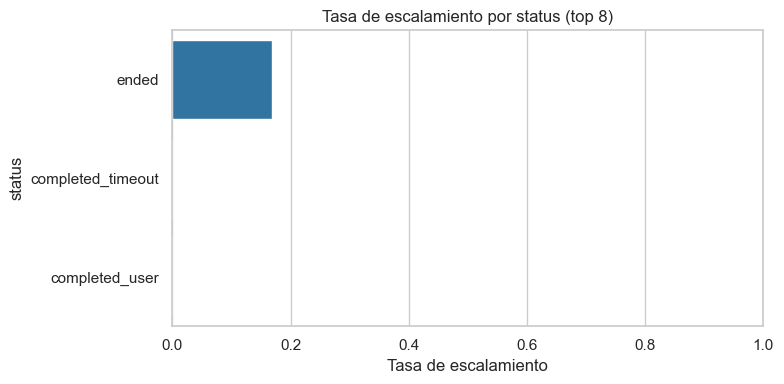

C:\Users\Admin\AppData\Local\Temp\ipykernel_26596\292121621.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("msg_bucket")["escalate_conversation"].mean().reset_index()


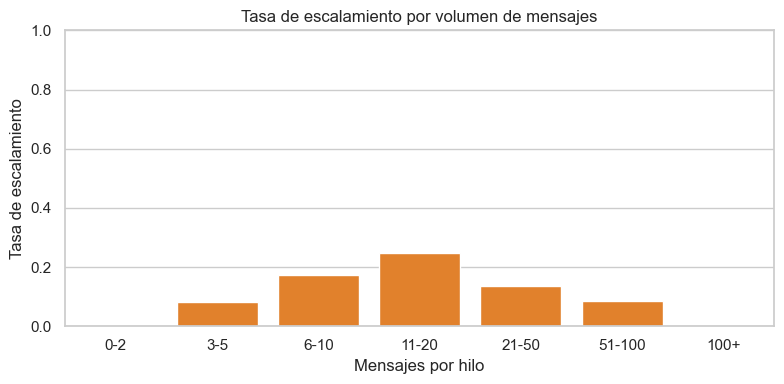

Metricas de impacto (resumen)
   tasa_escalamiento  duracion_promedio_min  duracion_p90_min  \
0           0.169043               5.864238           6.33049   

   mensajes_promedio  mensajes_p90  \
0          12.078279          23.0   

                                                      estado_top  
0  {"ended": 11291, "completed_user": 1, "completed_timeout": 1}  


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def _plot_escalamiento_por_categoria(df: pd.DataFrame, col: str, top_n: int = 10) -> None:
    if col not in df.columns or "escalate_conversation" not in df.columns:
        print(f"No se puede graficar por {col}.")
        return

    tmp = df[[col, "escalate_conversation"]].copy()
    tmp["escalate_conversation"] = tmp["escalate_conversation"].fillna(0).astype(int)

    rate = (
        tmp.groupby(col)["escalate_conversation"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
    )

    plt.figure(figsize=(8, 4))
    sns.barplot(data=rate, x="escalate_conversation", y=col, color="#1f77b4")
    plt.title(f"Tasa de escalamiento por {col} (top {top_n})")
    plt.xlabel("Tasa de escalamiento")
    plt.ylabel(col)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


def _plot_mensajes_vs_escalamiento(df: pd.DataFrame) -> None:
    if "msg_count" not in df.columns or "escalate_conversation" not in df.columns:
        print("No se puede graficar mensajes vs escalamiento.")
        return

    tmp = df[["msg_count", "escalate_conversation"]].copy()
    tmp["escalate_conversation"] = tmp["escalate_conversation"].fillna(0).astype(int)

    bins = [0, 2, 5, 10, 20, 50, 100, np.inf]
    labels = ["0-2", "3-5", "6-10", "11-20", "21-50", "51-100", "100+"]
    tmp["msg_bucket"] = pd.cut(tmp["msg_count"], bins=bins, labels=labels, include_lowest=True)

    rate = tmp.groupby("msg_bucket")["escalate_conversation"].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.barplot(data=rate, x="msg_bucket", y="escalate_conversation", color="#ff7f0e")
    plt.title("Tasa de escalamiento por volumen de mensajes")
    plt.xlabel("Mensajes por hilo")
    plt.ylabel("Tasa de escalamiento")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


sns.set_theme(style="whitegrid")

_plot_escalamiento_por_categoria(df_master, "status", top_n=8)
_plot_mensajes_vs_escalamiento(df_master)


def metricas_impacto_aerolinea(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        raise DataValidationError("No hay datos para calcular metricas.")

    required = {"escalate_conversation", "duration_minutes", "msg_count", "status"}
    available = required.intersection(df.columns)

    metrics: Dict[str, Any] = {}
    if "escalate_conversation" in available:
        target = df["escalate_conversation"].fillna(0).astype(int)
        metrics["tasa_escalamiento"] = target.mean()

    if "duration_minutes" in available:
        metrics["duracion_promedio_min"] = df["duration_minutes"].mean()
        metrics["duracion_p90_min"] = df["duration_minutes"].quantile(0.90)

    if "msg_count" in available:
        metrics["mensajes_promedio"] = df["msg_count"].mean()
        metrics["mensajes_p90"] = df["msg_count"].quantile(0.90)

    if "status" in available:
        metrics["estado_top"] = json.dumps(df["status"].value_counts().head(5).to_dict())

    metrics_df = pd.DataFrame([metrics])
    print("Metricas de impacto (resumen)")
    print(metrics_df)
    return metrics_df


_ = metricas_impacto_aerolinea(df_master)

## 6. Embeddings locales con Ollama + modelo

In [ ]:
import hashlib
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.exceptions import UndefinedMetricWarning
import warnings

from langchain_ollama import OllamaEmbeddings
from tqdm import tqdm


# CONFIGURACION
EMBEDDINGS_CACHE_PATH = Path("outputs") / "embeddings_cache.parquet"
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

MAX_CHARS = 1000
CHUNK_SIZE = 500


# DATA PREPARATION
def _preparar_dataset(df: pd.DataFrame) -> pd.DataFrame:
    required = {"full_conversation", "escalate_conversation"}
    missing = required - set(df.columns)
    if missing:
        raise DataValidationError(f"Faltan columnas: {missing}")

    df_model = df.copy()

    df_model["full_conversation"] = (
        df_model["full_conversation"]
        .fillna("")
        .str.slice(0, MAX_CHARS)
    )

    df_model = df_model[df_model["full_conversation"].str.len() > 0]
    df_model["target"] = df_model["escalate_conversation"].fillna(0).astype(int)

    return df_model


# TEXT UTILS
def chunk_text(text: str, chunk_size: int = CHUNK_SIZE) -> List[str]:
    words = text.split()
    return [
        " ".join(words[i:i + chunk_size])
        for i in range(0, len(words), chunk_size)
    ]


def _hash_text(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()


def _build_chunks_for_texts(texts: List[str]) -> Tuple[List[str], List[List[str]]]:
    all_chunks: List[str] = []
    text_to_hashes: List[List[str]] = []

    for text in texts:
        chunks = chunk_text(text)
        hashes = [_hash_text(chunk) for chunk in chunks]
        all_chunks.extend(chunks)
        text_to_hashes.append(hashes)

    return all_chunks, text_to_hashes


# CACHE
def _load_embeddings_cache(
    path: Path = EMBEDDINGS_CACHE_PATH
) -> Dict[str, List[float]]:

    if not path.exists():
        return {}

    cache_df = pd.read_parquet(path)
    return dict(zip(cache_df["text_hash"], cache_df["embedding"]))


def _save_embeddings_cache(
    cache: Dict[str, List[float]],
    path: Path = EMBEDDINGS_CACHE_PATH
) -> None:

    cache_df = pd.DataFrame({
        "text_hash": list(cache.keys()),
        "embedding": list(cache.values())
    })

    path.parent.mkdir(exist_ok=True)
    cache_df.to_parquet(path, index=False)
    logger.info("Cache actualizado: %s", path)


# EMBEDDINGS CORE
def _batch_iter(items: List[str], batch_size: int) -> Iterable[List[str]]:
    for i in range(0, len(items), batch_size):
        yield items[i:i + batch_size]


def generate_embeddings_with_cache(
    texts: List[str],
    model_name: str = "nomic-embed-text",
    batch_size: int = 64,
) -> List[List[float]]:

    if not texts:
        raise EmbeddingError("No hay textos para vectorizar.")

    embedder = OllamaEmbeddings(model=model_name)
    cache = _load_embeddings_cache()

    all_chunks, text_to_hashes = _build_chunks_for_texts(texts)
    unique_chunks = {}
    for chunk in all_chunks:
        chunk_hash = _hash_text(chunk)
        if chunk_hash not in unique_chunks and chunk_hash not in cache:
            unique_chunks[chunk_hash] = chunk

    missing_hashes = list(unique_chunks.keys())
    missing_chunks = [unique_chunks[h] for h in missing_hashes]

    if missing_chunks:
        for batch in tqdm(
            _batch_iter(missing_chunks, batch_size),
            desc="Vectorizando chunks",
        ):
            batch_embeddings = embedder.embed_documents(batch)
            for chunk_text, emb in zip(batch, batch_embeddings):
                cache[_hash_text(chunk_text)] = emb

        _save_embeddings_cache(cache)
    else:
        logger.info("Todos los chunks estaban en cache.")

    embeddings: List[List[float]] = []
    for hashes in text_to_hashes:
        chunk_embs = [cache[h] for h in hashes]
        embeddings.append(np.mean(chunk_embs, axis=0).tolist())

    return embeddings


# ML con Logistic Regression
def train_model(
    X_train: List[List[float]],
    y_train: pd.Series
) -> LogisticRegression:

    if len(np.unique(y_train)) < 2:
        raise ModelTrainingError("Target con una sola clase.")

    clf = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    )

    clf.fit(X_train, y_train)
    return clf


def save_model(model: LogisticRegression, version: str = "v1") -> Path:
    model_path = MODEL_DIR / f"model_{version}.joblib"
    joblib.dump(model, model_path)
    logger.info("Modelo guardado: %s", model_path)
    return model_path


def evaluate_model(model, X_test, y_test) -> None:

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\nREPORTE")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    print("\nMATRIZ CONFUSION")
    print(cm)
    print(f"Falsos Negativos: {cm[1][0]}")

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

    fn_cost = 5
    fp_cost = 1
    total_cost = cm[1][0]*fn_cost + cm[0][1]*fp_cost
    print(f"Costo Esperado: {total_cost}")


# PIPELINE
def entrenar_clasificador_embeddings(
    df: pd.DataFrame,
    model_name: str = "nomic-embed-text"
):

    df_model = _preparar_dataset(df)

    texts = df_model["full_conversation"].tolist()

    embeddings = generate_embeddings_with_cache(
        texts,
        model_name=model_name,
        batch_size=64,
    )

    X_train, X_test, y_train, y_test = train_test_split(
        embeddings,
        df_model["target"],
        test_size=0.2,
        random_state=42,
        stratify=df_model["target"]
    )

    clf = train_model(X_train, y_train)
    save_model(clf)

    evaluate_model(clf, X_test, y_test)

    return clf, X_test, y_test

# RUN
try:
    clf_model, X_test, y_test = entrenar_clasificador_embeddings(df_master)
except (EmbeddingError, ModelTrainingError, DataValidationError) as exc:
    logger.error("Error controlado: %s", exc)
except Exception as exc:
    logger.error("Error inesperado: %s", exc)


2026-02-09 14:50:27,711 - aerya - INFO - Todos los chunks estaban en cache.
2026-02-09 14:50:29,897 - aerya - INFO - Modelo guardado: models\model_v1.joblib



REPORTE
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1878
           1       0.52      0.87      0.65       381
           2       0.00      0.00      0.00         0

    accuracy                           0.84      2259
   macro avg       0.50      0.57      0.51      2259
weighted avg       0.89      0.84      0.85      2259


MATRIZ CONFUSION
[[1567  307    4]
 [  51  330    0]
 [   0    0    0]]
Falsos Negativos: 51
ROC-AUC: 0.9317
PR-AUC: 0.7980
Costo Esperado: 562


## 7. Agente LangGraph con OpenAI 


In [8]:
from typing import TypedDict, Annotated

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# 
# --- LLM Singleton ---
LLM = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def construir_resumen_contexto(df: pd.DataFrame) -> str:
    resumen = []
    if "escalate_conversation" in df.columns:
        tasa = df["escalate_conversation"].fillna(0).astype(int).mean()
        resumen.append(f"Tasa de escalamiento: {tasa:.3f}")
    if "duration_minutes" in df.columns:
        resumen.append(f"Duracion promedio (min): {df['duration_minutes'].mean():.2f}")
    if "msg_count" in df.columns:
        resumen.append(f"Mensajes promedio: {df['msg_count'].mean():.2f}")
    return "\n".join(resumen)

def construir_system_prompt(contexto: str) -> str:
    return (
        "Rol: Analista de operaciones de una aerolinea.\n"
        "Objetivo: Responder preguntas de negocio con base en metricas.\n"
        "Restricciones: No revelar razonamiento interno. No usar emojis.\n"
        "Formato de salida: JSON con llaves summary, insights, risks, actions, metrics_used.\n"
        "Ejemplo de salida:\n"
        "{\n"
        "  \"summary\": \"La tasa de escalamiento es elevada en ciertos estados.\",\n"
        "  \"insights\": [\"Los hilos con mas mensajes muestran mayor escalamiento.\"],\n"
        "  \"risks\": [\"Falsos negativos impactan la satisfaccion del cliente.\"],\n"
        "  \"actions\": [\"Priorizar mejora en los estados con mayor tasa.\"],\n"
        "  \"metrics_used\": [\"tasa_escalamiento\", \"mensajes_promedio\"]\n"
        "}\n\n"
        f"Contexto:\n{contexto}"
    )

def _safe_datetime_series(series: pd.Series) -> pd.Series:
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    return pd.to_datetime(series.map(lambda x: x.get("$date") if isinstance(x, dict) else x), errors="coerce")


def _get_conversation_text(df: pd.DataFrame, thread_id: Optional[str]) -> str:
    if not thread_id or "thread_id" not in df.columns:
        return ""

    match = df[df["thread_id"].astype(str) == str(thread_id)]
    if match.empty:
        return ""

    if "full_conversation" in df.columns:
        return str(match["full_conversation"].iloc[0])

    text_cols = [c for c in ["content", "message_text", "text", "body"] if c in df.columns]
    if text_cols:
        return "\n".join(match[text_cols[0]].astype(str).tolist())

    return ""

# --- CORRECCIÓN 2: Clausura (Closure) para Tools ---
# Evita depender de una variable global 'df_master' inestable.
def build_tools(df: pd.DataFrame):
    
    @tool
    def obtener_metricas_resumen() -> str:
        """Devuelve un resumen de metricas clave de la aerolinea."""
        return construir_resumen_contexto(df)

    @tool
    def top_hilos_por_mensajes(n: int = 5) -> str:
        """Devuelve los top hilos con mas mensajes y su conteo."""
        if "msg_count" not in df.columns:
            return "No existe la columna msg_count."
        top_df = df[["thread_id", "msg_count"]].sort_values("msg_count", ascending=False).head(n)
        return top_df.to_string(index=False)

    @tool
    def top_hilos_por_duracion(n: int = 5) -> str:
        """Devuelve los top hilos con mayor duracion (min)."""
        if "duration_minutes" not in df.columns:
            return "No existe la columna duration_minutes."
        top_df = df[["thread_id", "duration_minutes"]].sort_values(
            "duration_minutes", ascending=False
        ).head(n)
        return top_df.to_string(index=False)

    @tool
    def tasa_escalamiento_por_categoria(col: str = "status", top_n: int = 8) -> str:
        """Calcula la tasa de escalamiento por categoria (status, platform, source)."""
        if col not in df.columns or "escalate_conversation" not in df.columns:
            return f"No existe la columna {col} o escalate_conversation."
        tmp = df[[col, "escalate_conversation"]].copy()
        tmp["escalate_conversation"] = tmp["escalate_conversation"].fillna(0).astype(int)
        rate = (
            tmp.groupby(col)["escalate_conversation"]
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .reset_index()
        )
        return rate.to_string(index=False)

    @tool
    def resumen_tiempos_operativos() -> str:
        """Devuelve estadisticas de duracion y volumen de mensajes."""
        if "duration_minutes" not in df.columns or "msg_count" not in df.columns:
            return "No existen columnas de duracion o mensajes."
        stats: Dict[str, float] = {
            "duracion_promedio_min": df["duration_minutes"].mean(),
            "duracion_p90_min": df["duration_minutes"].quantile(0.90),
            "mensajes_promedio": df["msg_count"].mean(),
            "mensajes_p90": df["msg_count"].quantile(0.90),
        }
        return pd.DataFrame([stats]).to_string(index=False)

    @tool
    def tendencia_escalamiento_mensual() -> str:
        """Muestra la tendencia mensual de escalamiento."""
        if "created_at" not in df.columns or "escalate_conversation" not in df.columns:
            return "No existen columnas requeridas para tendencia mensual."
        tmp = df[["created_at", "escalate_conversation"]].copy()
        tmp["created_at"] = _safe_datetime_series(tmp["created_at"])
        tmp = tmp.dropna(subset=["created_at"])
        tmp["month"] = tmp["created_at"].dt.to_period("M").astype(str)
        tmp["escalate_conversation"] = tmp["escalate_conversation"].fillna(0).astype(int)
        trend = tmp.groupby("month")["escalate_conversation"].mean().reset_index()
        return trend.to_string(index=False)

    @tool
    def obtener_conversacion_por_thread(thread_id: str) -> str:
        """Devuelve la conversacion completa para un thread_id."""
        text = _get_conversation_text(df, thread_id)
        if not text:
            return "No se encontro conversacion para ese thread_id."
        return text

    return [
        obtener_metricas_resumen, top_hilos_por_mensajes, top_hilos_por_duracion,
        tasa_escalamiento_por_categoria, resumen_tiempos_operativos, tendencia_escalamiento_mensual,
        obtener_conversacion_por_thread
    ]

# Referencia al dataframe para los nodos del grafo (evita globals dispersos)
_DF_REF: Optional[pd.DataFrame] = None

# Inicializamos las tools usando el df_master (que debe existir en el notebook)
# Si no existe, usamos una lista vacia para evitar error de definición
try:
    _DF_REF = df_master
    TOOLS = build_tools(df_master)
except NameError:
    TOOLS = []

LLM_WITH_TOOLS = LLM.bind_tools(TOOLS) if TOOLS else LLM

MAX_TOOL_CALLS = 3

# --- CORRECCIÓN 6: Tipado Fuerte ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    tool_calls_count: int
    thread_id: Optional[str]
    route: Optional[str]
    analysis: Dict[str, str]

def _parse_json_response(text: str) -> Dict[str, str]:
    try:
        return json.loads(text)
    except (json.JSONDecodeError, ValueError, TypeError):
        return {}


def nodo_router(state: AgentState) -> AgentState:
    if "messages" not in state or not state["messages"]:
        raise ValueError("Estado invalido: messages vacio")

    thread_id = state.get("thread_id")
    conversation_text = _get_conversation_text(_DF_REF, thread_id) if _DF_REF is not None else ""

    router_prompt = (
        "Rol: Analista de conversaciones automatizado.\n"
        "Tarea: Clasificar sentimiento y motivo, y decidir la ruta.\n"
        "Reglas de ruteo:\n"
        "- Si el sentimiento es negativo o hay queja fuerte: route = escalar\n"
        "- Si la consulta es tecnica: route = tecnico\n"
        "- Si la conversacion parece resuelta: route = resumen\n"
        "- Si no hay thread_id o conversacion: route = assistant\n"
        "Devuelve SOLO JSON con llaves: route, sentiment, motivo, rationale.\n"
    )

    last_user = state["messages"][-1].content if hasattr(state["messages"][-1], "content") else ""
    router_input = (
        f"thread_id: {thread_id}\n"
        f"conversacion:\n{conversation_text}\n\n"
        f"pregunta_actual:\n{last_user}"
    )

    response = LLM.invoke([
        SystemMessage(content=router_prompt),
        HumanMessage(content=router_input),
    ])

    analysis = _parse_json_response(getattr(response, "content", ""))
    route = analysis.get("route", "assistant")

    return {
        "messages": state["messages"] + [response],
        "tool_calls_count": state.get("tool_calls_count", 0),
        "thread_id": thread_id,
        "route": route,
        "analysis": analysis,
    }


def nodo_escalar_humano(state: AgentState) -> AgentState:
    analysis = state.get("analysis", {})
    thread_id = state.get("thread_id")
    conversation_text = _get_conversation_text(_DF_REF, thread_id) if _DF_REF is not None else ""

    prompt = (
        "Rol: Analista de conversaciones automatizado.\n"
        "Tarea: Generar salida de escalamiento a humano.\n"
        "Devuelve SOLO JSON con llaves: action, sentiment, motivo, summary, next_steps.\n"
        "action debe ser 'escalar_humano'."
    )

    response = LLM.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content=f"analisis: {analysis}\n\nconversacion:\n{conversation_text}"),
    ])

    return {
        "messages": state["messages"] + [response],
        "tool_calls_count": state.get("tool_calls_count", 0),
    }


def nodo_respuesta_tecnica(state: AgentState) -> AgentState:
    analysis = state.get("analysis", {})
    thread_id = state.get("thread_id")
    conversation_text = _get_conversation_text(_DF_REF, thread_id) if _DF_REF is not None else ""

    prompt = (
        "Rol: Analista de conversaciones automatizado.\n"
        "Tarea: Generar borrador de respuesta tecnica.\n"
        "Devuelve SOLO JSON con llaves: action, sentiment, motivo, respuesta, assumptions.\n"
        "action debe ser 'borrador_tecnico'."
    )

    response = LLM.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content=f"analisis: {analysis}\n\nconversacion:\n{conversation_text}"),
    ])

    return {
        "messages": state["messages"] + [response],
        "tool_calls_count": state.get("tool_calls_count", 0),
    }


def nodo_resumen_resuelto(state: AgentState) -> AgentState:
    analysis = state.get("analysis", {})
    thread_id = state.get("thread_id")
    conversation_text = _get_conversation_text(_DF_REF, thread_id) if _DF_REF is not None else ""

    prompt = (
        "Rol: Analista de conversaciones automatizado.\n"
        "Tarea: Generar resumen final de conversacion resuelta.\n"
        "Devuelve SOLO JSON con llaves: action, sentiment, motivo, summary, resolution.\n"
        "action debe ser 'resumen'."
    )

    response = LLM.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content=f"analisis: {analysis}\n\nconversacion:\n{conversation_text}"),
    ])

    return {
        "messages": state["messages"] + [response],
        "tool_calls_count": state.get("tool_calls_count", 0),
    }


def nodo_asistente(state: AgentState) -> AgentState:
    # --- CORRECCIÓN 3: Validación de Input ---
    if "messages" not in state or not state["messages"]:
        raise ValueError("Estado invalido: messages vacio")

    try:
        response = LLM_WITH_TOOLS.invoke(
            state["messages"] + [
                SystemMessage(content="IMPORTANTE: Devuelve SOLO un JSON válido con las claves solicitadas.")
            ]
        )
    except Exception as exc:
        # --- CORRECCIÓN 4: Logging ---
        logger.error(f"Error invocando LLM: {exc}")
        raise AgentError(f"Fallo del LLM: {exc}") from exc

    tool_calls_count = state.get("tool_calls_count", 0)
    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_calls_count += 1

    return {
        "messages": state["messages"] + [response],
        "tool_calls_count": tool_calls_count,
        "thread_id": state.get("thread_id"),
        "route": state.get("route"),
        "analysis": state.get("analysis", {}),
    }

def construir_grafo() -> StateGraph:
    tools_node = ToolNode(TOOLS)

    def route_after_router(state: AgentState) -> str:
        """Decide el siguiente nodo segun la ruta del router."""
        ruta = state.get("route", "assistant")
        if ruta == "escalar":
            return "escalar"
        if ruta == "tecnico":
            return "tecnico"
        if ruta == "resumen":
            return "resumen"
        return "assistant"

    def route_after_assistant(state: AgentState):
        """Decide si el asistente necesita tools o termina."""
        if state.get("tool_calls_count", 0) >= MAX_TOOL_CALLS:
            return END

        last_msg = state["messages"][-1]
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            return "tools"
        return END

    graph = StateGraph(AgentState)

    # Nodos
    graph.add_node("router", nodo_router)
    graph.add_node("assistant", nodo_asistente)
    graph.add_node("tools", tools_node)
    graph.add_node("escalar", nodo_escalar_humano)
    graph.add_node("tecnico", nodo_respuesta_tecnica)
    graph.add_node("resumen", nodo_resumen_resuelto)

    # Entry point: el router analiza y decide la ruta
    graph.set_entry_point("router")

    # Router -> ruta especializada o asistente general
    graph.add_conditional_edges(
        "router",
        route_after_router,
        {
            "escalar": "escalar",
            "tecnico": "tecnico",
            "resumen": "resumen",
            "assistant": "assistant",
        },
    )

    # Nodos especializados -> END
    graph.add_edge("escalar", END)
    graph.add_edge("tecnico", END)
    graph.add_edge("resumen", END)

    # Asistente general -> tools loop
    graph.add_conditional_edges(
        "assistant",
        route_after_assistant,
        {"tools": "tools", END: END},
    )
    graph.add_edge("tools", "assistant")

    return graph

GRAPH_TEMPLATE = construir_grafo()
AGENT_APPS: Dict[str, Any] = {}

def get_agent_app(session_id: str):
    if session_id not in AGENT_APPS:
        AGENT_APPS[session_id] = GRAPH_TEMPLATE.compile(checkpointer=MemorySaver())
    return AGENT_APPS[session_id]

## 7.A Memoria semantica FAISS 



In [9]:
from memory.faiss_memory import FaissMemory

logging.getLogger("faiss.loader").setLevel(logging.WARNING)

MEMORY_ENABLED = True
MEMORY = None

try:
    embeddings = OllamaEmbeddings(model="nomic-embed-text")
    MEMORY = FaissMemory(
        index_path=Path("outputs") / "faiss.index",
        metadata_path=Path("outputs") / "faiss_metadata.json",
        embeddings=embeddings,
    )
except Exception as exc:
    MEMORY_ENABLED = False
    MEMORY = None
    logger.warning("Memoria FAISS deshabilitada: %s", exc)


def get_semantic_context(query: str, k: int = 3) -> str:
    """Recupera contexto semantico relevante. Devuelve string listo para prompt."""
    if not MEMORY_ENABLED or MEMORY is None or not query:
        return ""

    hits = MEMORY.search(query, k=k)
    if not hits:
        return ""

    return "\n".join([f"- {h['text']}" for h in hits])


def save_semantic_memory(
    question: str,
    answer: str,
    thread_id: str | None = None,
    session_id: str | None = None,
) -> None:
    """Guarda un par pregunta-respuesta en memoria semantica."""
    if not MEMORY_ENABLED or MEMORY is None or not answer:
        return

    MEMORY.save(
        text=f"Pregunta: {question}\nRespuesta: {answer}",
        metadata={"thread_id": thread_id, "session_id": session_id},
    )


2026-02-09 14:50:33,184 - faiss.loader - INFO - Loading faiss with AVX512 support.
2026-02-09 14:50:33,184 - faiss.loader - INFO - Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
2026-02-09 14:50:33,184 - faiss.loader - INFO - Loading faiss with AVX2 support.
2026-02-09 14:50:33,393 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2026-02-09 14:50:35,653 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


## 8. Ejecucion del agente

In [10]:
try:
    if "df_master" not in globals():
        if "df_threads" in globals() and "df_messages" in globals():
            df_master = crear_tabla_maestra(df_threads, df_messages)
        else:
            df_master_path = Path("outputs") / "df_master.parquet"
            if df_master_path.exists():
                df_master = pd.read_parquet(df_master_path)
            else:
                raise DataValidationError(
                    "df_master no esta cargado. Ejecuta la seccion de tabla maestra primero."
                )

    contexto = construir_resumen_contexto(df_master)
    system_prompt = construir_system_prompt(contexto)

    session_id = "aerya-demo"
    app = get_agent_app(session_id)

    thread_id = None
    if "thread_id" in df_master.columns and not df_master.empty:
        thread_id = str(df_master["thread_id"].iloc[0])

    user_question = "Cual es la tasa de escalamiento por estado y cuales son los hilos con mayor duracion?"

    semantic_context = get_semantic_context(user_question, k=3)
    if semantic_context:
        system_prompt = f"{system_prompt}\n\nContexto semantico relevante:\n{semantic_context}"

    print("Iniciando flujo del agente...")
    for event in app.stream(
        {
            "messages": [
                SystemMessage(content=system_prompt),
                HumanMessage(content=user_question),
            ],
            "tool_calls_count": 0,
            "thread_id": thread_id,
            "route": None,
            "analysis": {},
        },
        config={"configurable": {"thread_id": session_id}, "recursion_limit": 6},
    ):
        for value in event.values():
            if "messages" in value:
                last_msg = value["messages"][-1]
                if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
                    print("\nAgente solicita herramientas:")
                    for tool_call in last_msg.tool_calls:
                        print(f"  - {tool_call['name']}")
                elif hasattr(last_msg, "content") and last_msg.content:
                    if last_msg.content.strip():
                        print("\nRespuesta:")
                        print(last_msg.content)

                        try:
                            json.loads(last_msg.content)
                            save_semantic_memory(
                                question=user_question,
                                answer=last_msg.content,
                                thread_id=thread_id,
                                session_id=session_id,
                            )
                        except (json.JSONDecodeError, ValueError):
                            logger.debug("Respuesta no es JSON valido, no se guarda en memoria.")

except AgentError as exc:
    logger.error("Error en el agente: %s", exc)
    fallback = {
        "summary": "No fue posible consultar el agente en este momento.",
        "insights": [],
        "risks": ["La respuesta se entrega en modo degradado."],
        "actions": ["Reintentar la consulta o validar la clave de API."],
        "metrics_used": [],
    }
    print("Fallback JSON:")
    print(json.dumps(fallback, indent=2, ensure_ascii=False))
except Exception as exc:
    logger.error("Error inesperado en el agente: %s", exc)

2026-02-09 14:50:35,864 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


Iniciando flujo del agente...


2026-02-09 14:50:37,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Respuesta:
```json
{
  "route": "assistant",
  "sentiment": "neutral",
  "motivo": "consulta sobre tasas de escalamiento y duración de hilos",
  "rationale": "La conversación no presenta quejas ni problemas técnicos, y la pregunta actual es informativa."
}
```


2026-02-09 14:50:39,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Agente solicita herramientas:
  - tasa_escalamiento_por_categoria
  - top_hilos_por_duracion

Respuesta:
               thread_id  duration_minutes
           1762697576971       7362.599533
6974d4f5d52e9d1dd1205fce       4066.875917
6974d4f5d52e9d1dd1205fce       4066.875917
6974d4f5d52e9d1dd1205fce       4066.875917
6974d4f5d52e9d1dd1205fce       4066.875917


2026-02-09 14:50:41,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Respuesta:
{
  "summary": "La tasa de escalamiento por estado muestra que el estado 'ended' tiene una tasa de 0.169, mientras que otros estados no presentan escalamiento.",
  "insights": ["El estado 'ended' es el único con tasa de escalamiento significativa.", "Los hilos con mayor duración tienen tiempos de 7362.60 minutos y 4066.88 minutos."],
  "risks": ["La falta de escalamiento en otros estados puede indicar problemas operativos."],
  "actions": ["Analizar las causas del escalamiento en el estado 'ended'.", "Investigar los hilos de mayor duración para identificar oportunidades de mejora."],
  "metrics_used": ["tasa_escalamiento", "duracion_hilos"]
}


2026-02-09 14:50:42,513 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


## 8.1 Evaluacion de calidad del agente

In [11]:
import time
import uuid


EXPECTED_KEYS = {"summary", "insights", "risks", "actions", "metrics_used"}

_JSON_REGEX = re.compile(r"\{[\s\S]*\}")


def _extract_json(text: str) -> Optional[str]:
    """Extrae el primer bloque JSON de un texto, incluso si tiene texto alrededor."""
    match = _JSON_REGEX.search(text)
    return match.group(0) if match else None


def evaluar_respuesta_agente(raw_response: str) -> Dict[str, Any]:
    """Evalua la calidad de una respuesta del agente."""
    result: Dict[str, Any] = {
        "json_valido": False,
        "claves_presentes": [],
        "claves_faltantes": [],
        "score_estructura": 0.0,
        "insights_no_vacios": False,
        "actions_no_vacios": False,
    }

    json_str = _extract_json(raw_response) if raw_response else None

    try:
        parsed = json.loads(json_str) if json_str else json.loads(raw_response)
        result["json_valido"] = True
    except (json.JSONDecodeError, ValueError, TypeError):
        result["claves_faltantes"] = list(EXPECTED_KEYS)
        return result

    presentes = EXPECTED_KEYS.intersection(parsed.keys())
    faltantes = EXPECTED_KEYS - presentes

    result["claves_presentes"] = sorted(presentes)
    result["claves_faltantes"] = sorted(faltantes)
    result["score_estructura"] = len(presentes) / len(EXPECTED_KEYS)

    if "insights" in parsed and isinstance(parsed["insights"], list):
        result["insights_no_vacios"] = len(parsed["insights"]) > 0

    if "actions" in parsed and isinstance(parsed["actions"], list):
        result["actions_no_vacios"] = len(parsed["actions"]) > 0

    return result


def ejecutar_evaluacion_agente(
    preguntas: List[str],
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Ejecuta multiples preguntas en sesiones aisladas y evalua las respuestas."""
    resultados = []

    contexto = construir_resumen_contexto(df)
    system_prompt = construir_system_prompt(contexto)

    for pregunta in preguntas:
        eval_session = f"eval-{uuid.uuid4().hex[:8]}"
        eval_app = get_agent_app(eval_session)

        t0 = time.time()
        try:
            res = eval_app.invoke(
                {
                    "messages": [
                        SystemMessage(content=system_prompt),
                        HumanMessage(content=pregunta),
                    ],
                    "tool_calls_count": 0,
                    "thread_id": None,
                    "route": None,
                    "analysis": {},
                },
                config={"configurable": {"thread_id": eval_session}, "recursion_limit": 6},
            )
            answer = res["messages"][-1].content
        except Exception as exc:
            answer = str(exc)

        elapsed = time.time() - t0
        evaluacion = evaluar_respuesta_agente(answer)
        evaluacion["pregunta"] = pregunta[:80]
        evaluacion["tiempo_s"] = round(elapsed, 2)
        resultados.append(evaluacion)

    return pd.DataFrame(resultados)


# --- Ejecucion ---

PREGUNTAS_EVAL = [
    "Que factores afectan el escalamiento?",
    "Cual es la duracion promedio de las conversaciones?",
    "Cuales son los estados con mayor tasa de escalamiento?",
]

try:
    df_eval = ejecutar_evaluacion_agente(PREGUNTAS_EVAL, df_master)

    print("Agent Response Quality Check n")
    print(df_eval[["pregunta", "json_valido", "score_estructura", "tiempo_s"]].to_string(index=False))
    print(f"\nScore promedio de estructura: {df_eval['score_estructura'].mean():.0%}")
    print(f"Respuestas JSON validas: {df_eval['json_valido'].sum()}/{len(df_eval)}")
    print(f"Tiempo promedio: {df_eval['tiempo_s'].mean():.1f}s")
except Exception as exc:
    logger.error("Error en evaluacion del agente: %s", exc)

2026-02-09 14:50:43,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:45,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:46,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:48,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:49,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:51,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-09 14:50:53,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Agent Response Quality Check n
                                              pregunta  json_valido  score_estructura  tiempo_s
                 Que factores afectan el escalamiento?         True               1.0      2.66
   Cual es la duracion promedio de las conversaciones?         True               1.0      3.28
Cuales son los estados con mayor tasa de escalamiento?         True               1.0      4.61

Score promedio de estructura: 100%
Respuestas JSON validas: 3/3
Tiempo promedio: 3.5s


## 9. Persistencia opcional de resultados

In [12]:
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

DF_MASTER_PATH = OUTPUT_DIR / "df_master.parquet"


def cargar_df_master_si_existe(path: Path = DF_MASTER_PATH) -> pd.DataFrame | None:
    if path.exists():
        logger.info("Cargando desde: %s", path)
        return pd.read_parquet(path)
    return None


def obtener_df_master(
    df_t: pd.DataFrame,
    df_m: pd.DataFrame,
    force_rebuild: bool = False,
    persist: bool = False,
) -> pd.DataFrame:
    if not force_rebuild:
        cached = cargar_df_master_si_existe()
        if cached is not None:
            return cached

    df_master_local = crear_tabla_maestra(df_t, df_m)
    if persist:
        df_master_local.to_parquet(DF_MASTER_PATH, index=False)
        logger.info("Guardado: %s", DF_MASTER_PATH)
    return df_master_local


def guardar_metricas(df: pd.DataFrame, path_dir: Path = OUTPUT_DIR) -> None:
    metrics_df = metricas_impacto_aerolinea(df)
    metrics_df.to_csv(path_dir / "metricas_impacto.csv", index=False)
    logger.info("Guardado: %s", path_dir / "metricas_impacto.csv")


def guardar_embeddings(df_embeddings: pd.DataFrame, path_dir: Path = OUTPUT_DIR) -> None:
    df_embeddings.to_parquet(path_dir / "df_embeddings.parquet", index=False)
    logger.info("Guardado: %s", path_dir / "df_embeddings.parquet")


# Uso recomendado:
# df_master = obtener_df_master(df_threads, df_messages, force_rebuild=False, persist=False)
# guardar_metricas(df_master)
# guardar_embeddings(df_embeddings)

## 10. API REST (FastAPI) - servicio en la nube

In [13]:
import uuid
import signal
from contextlib import contextmanager

from fastapi import FastAPI, Header, HTTPException, Request
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, ConfigDict, Field
from slowapi import Limiter
from slowapi.util import get_remote_address
from slowapi.errors import RateLimitExceeded
from slowapi.middleware import SlowAPIMiddleware


# --- Config ---

API_KEY = os.environ.get("AERYA_API_KEY")
if not API_KEY:
    logger.warning("AERYA_API_KEY no definida. Usando key de desarrollo.")
    API_KEY = "dev-key-local"

MAX_QUESTION_LENGTH = 2000
AGENT_TIMEOUT_S = 30


# --- Modelos Pydantic ---

class AskRequest(BaseModel):
    question: str = Field(..., min_length=1, max_length=MAX_QUESTION_LENGTH)
    session_id: str | None = Field(None, max_length=128)
    thread_id: str | None = None


class AskResponse(BaseModel):
    answer: str
    session_id: str


class HealthResponse(BaseModel):
    status: str
    graph_loaded: bool
    memory_enabled: bool
    llm_reachable: bool
    active_sessions: int


class MetricsResponse(BaseModel):
    model_config = ConfigDict(extra="allow")


class ErrorResponse(BaseModel):
    error: str


# --- App ---

limiter = Limiter(key_func=get_remote_address)

api = FastAPI(
    title="Aerya REST API",
    description=(
        "API REST para el agente de analisis de conversaciones de la aerolinea.\n\n"
        "**Autenticacion**: Header X-API-Key requerido en endpoints protegidos.\n\n"
        "**Rate Limit**: 10 requests/minuto por cliente en /v1/agent/query."
    ),
    version="1.0.0",
)

api.state.limiter = limiter
api.add_middleware(SlowAPIMiddleware)
api.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)


# --- Timeout helper ---

class AgentTimeoutError(Exception):
    pass


@contextmanager
def timeout(seconds: int):
    """Timeout context manager (solo Unix). En Windows se usa como fallback sin efecto."""
    if hasattr(signal, "SIGALRM"):
        def handler(signum, frame):
            raise AgentTimeoutError(f"El agente excedio el timeout de {seconds}s.")
        old = signal.signal(signal.SIGALRM, handler)
        signal.alarm(seconds)
        try:
            yield
        finally:
            signal.alarm(0)
            signal.signal(signal.SIGALRM, old)
    else:
        yield


# --- Dependencia: validacion de API key ---

def validate_api_key(x_api_key: str = Header(..., alias="X-API-Key")) -> str:
    if x_api_key != API_KEY:
        raise HTTPException(status_code=401, detail="API key invalida o ausente.")
    return x_api_key


# --- Endpoints (versionado /v1) ---

@api.get(
    "/v1/health",
    response_model=HealthResponse,
    tags=["System"],
    summary="Diagnostico del sistema",
    responses={200: {"description": "Estado actual de todos los componentes"}},
)
def health_check():
    llm_ok = True
    try:
        LLM.invoke("ping")
    except Exception:
        llm_ok = False

    return HealthResponse(
        status="ok" if llm_ok else "degraded",
        graph_loaded=GRAPH_TEMPLATE is not None,
        memory_enabled=MEMORY_ENABLED,
        llm_reachable=llm_ok,
        active_sessions=len(AGENT_APPS),
    )


@api.get(
    "/v1/metrics",
    response_model=MetricsResponse,
    tags=["Analytics"],
    summary="Metricas de negocio de la aerolinea",
    responses={
        401: {"model": ErrorResponse, "description": "API key invalida"},
        500: {"model": ErrorResponse, "description": "Error interno"},
    },
)
def get_metrics(x_api_key: str = Header(..., alias="X-API-Key")):
    validate_api_key(x_api_key)
    try:
        metrics_df = metricas_impacto_aerolinea(df_master)
        return metrics_df.to_dict(orient="records")[0]
    except Exception as exc:
        logger.error("Error en /v1/metrics: %s", exc)
        raise HTTPException(status_code=500, detail=str(exc))


@api.post(
    "/v1/agent/query",
    response_model=AskResponse,
    tags=["Agent"],
    summary="Consultar al agente de IA",
    responses={
        401: {"model": ErrorResponse, "description": "API key invalida"},
        429: {"model": ErrorResponse, "description": "Rate limit excedido"},
        504: {"model": ErrorResponse, "description": "Timeout del agente"},
        500: {"model": ErrorResponse, "description": "Error interno"},
    },
)
@limiter.limit("10/minute")
def agent_query(request: Request, req: AskRequest, x_api_key: str = Header(..., alias="X-API-Key")):
    validate_api_key(x_api_key)

    session_id = req.session_id or str(uuid.uuid4())

    logger.info(
        "agent_request",
        extra={"session_id": session_id, "thread_id": req.thread_id},
    )

    try:
        contexto = construir_resumen_contexto(df_master)
        system_prompt = construir_system_prompt(contexto)

        semantic_context = get_semantic_context(req.question, k=3)
        if semantic_context:
            system_prompt = f"{system_prompt}\n\nContexto semantico relevante:\n{semantic_context}"

        app_graph = get_agent_app(session_id)

        with timeout(AGENT_TIMEOUT_S):
            result = app_graph.invoke(
                {
                    "messages": [
                        SystemMessage(content=system_prompt),
                        HumanMessage(content=req.question),
                    ],
                    "tool_calls_count": 0,
                    "thread_id": req.thread_id,
                    "route": None,
                    "analysis": {},
                },
                config={"configurable": {"thread_id": session_id}, "recursion_limit": 6},
            )

        answer = result["messages"][-1].content

        try:
            json.loads(answer)
            save_semantic_memory(
                question=req.question,
                answer=answer,
                thread_id=req.thread_id,
                session_id=session_id,
            )
        except (json.JSONDecodeError, ValueError):
            logger.debug("Respuesta no es JSON valido, no se guarda en memoria.")

        logger.info(
            "agent_response",
            extra={"session_id": session_id, "answer_length": len(answer)},
        )

        return AskResponse(answer=answer, session_id=session_id)

    except AgentTimeoutError:
        logger.warning("Timeout en /v1/agent/query session=%s", session_id)
        raise HTTPException(status_code=504, detail=f"El agente excedio el timeout de {AGENT_TIMEOUT_S}s.")

    except Exception as exc:
        logger.error("Error en /v1/agent/query session=%s: %s", session_id, exc)
        raise HTTPException(status_code=500, detail=str(exc))

2026-02-09 14:50:54,358 - aerya - WARNING - AERYA_API_KEY no definida. Usando key de desarrollo.


## 12. Servidor local (demo)

In [14]:
import uvicorn

config = uvicorn.Config(api, host="0.0.0.0", port=8000)
server = uvicorn.Server(config)

print("API activa en: http://localhost:8000/docs")
await server.serve()

INFO:     Started server process [26596]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


API activa en: http://localhost:8000/docs


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [26596]
